In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
from matplotlib.cm import ScalarMappable

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skewnorm
from scipy.special import erf
import matplotlib.cm as cm
import matplotlib
import matplotlib.colors as colors
import os
import sys
import pickle

In [16]:

# Get the current working directory
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, ".."))

# Navigate to the sibling directory
sibling_dir = os.path.join(parent_dir, "00_analytical_function_setup")

# Add the sibling directory to sys.path for importing
if sibling_dir not in sys.path:
    sys.path.append(sibling_dir)

# Import the module from 00_analytical_function_setup
import analytical as a


## Load data

In [17]:

# Loading the reference landscape data
with open('data/reference_landscape_reward.pkl', 'rb') as file:
    reference_landscape = pickle.load(file)


with open('data/reference_threshold_vec.pkl', 'rb') as file:
    reference_threshold = pickle.load(file)



In [18]:
# Load smoothness and skewness data
skewness_df = pd.read_csv('data/Reward_Cumulative_20240606064755_landscape.csv')
smoothness_df = pd.read_csv('data/smoothness_analytical.csv')

In [19]:
skew_threshold_vec,alpha_val,skewsimresults=a.df_to_simresults(skewness_df,num_cols=11)
smooth_threshold_vec,corr_val,smoothsimresults=a.df_to_simresults(smoothness_df,num_cols=11)


In [20]:
## recover skewness values based on alpha values
skew_val=np.zeros(len(alpha_val))
for i in range(len(skew_val)):
    skew_val[i]=a.calculate_skewness(alpha_val[i])


In [21]:
# compute the optimal threshold
skew_optimum, skew_reward_at_optimum = a.get_optimum_thresh_reward(skew_val,skewsimresults,skew_threshold_vec)
corr_optimum, corr_reward_at_optimum = a.get_optimum_thresh_reward(corr_val,smoothsimresults,smooth_threshold_vec)

## Plotting

In [22]:
# Custom black color
myblack = "#222222"
myaccent=myblack
mediumgrey='#abadaa'
lightgrey="#D3D3D3"
# Set font globally
matplotlib.rcParams['font.family'] = 'Helvetica, Arial, sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica, Arial, sans-serif'  # Fallback to Arial if Helvetica is not available
dpi=300

In [23]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate a colormap to a specified range of values.

    This function creates a new colormap by selecting a subset of an existing colormap, 
    effectively "zooming in" on a specific range of the original color scale.

    Parameters:
    - cmap: A matplotlib colormap instance to be truncated.
    - minval: The minimum value of the colormap to include in the truncated version (default is 0.0).
    - maxval: The maximum value of the colormap to include in the truncated version (default is 1.0).
    - n: The number of discrete colors to include in the truncated colormap (default is 100).

    Returns:
    - new_cmap: A truncated LinearSegmentedColormap instance.
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [24]:
skip0=0 # do not skip 0
smooth_threshold_vec_skip0=smooth_threshold_vec
smoothsimresults_skip0 = smoothsimresults

skew_threshold_vec_skip0=skew_threshold_vec
skewsimresults_skip0 = skewsimresults

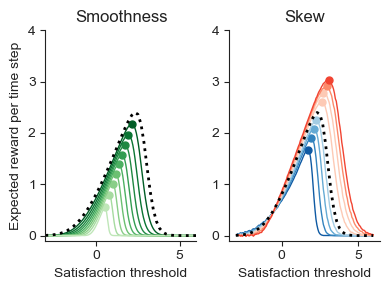

In [32]:
num_curves1 = smoothsimresults.shape[1]
num_curves2 = skewsimresults.shape[1]

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(4, 3),dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])


# Define colormap
cmap = truncate_colormap(plt.get_cmap('Greens_r'),0.,0.8)
norm = plt.Normalize(vmin=0, vmax=num_curves1-1)
sm = ScalarMappable(norm=norm, cmap=cmap)

# Define two colormaps
cmap_before = truncate_colormap(plt.get_cmap('Blues_r'),0,0.8)  # Colormap for curves before index 6
cmap_after =  truncate_colormap(plt.get_cmap('Reds'),0.2,1)     # Colormap for curves after index 6

# Normalization for each segment
norm_before = plt.Normalize(vmin=0, vmax=5)  # Assuming index 6 is exclusive
norm_after = plt.Normalize(vmin=0, vmax=num_curves2-7)  # Adjusting for the number of curves after index 6

# ScalarMappable instances for each segment
sm_before = ScalarMappable(norm=norm_before, cmap=cmap_before)
sm_after = ScalarMappable(norm=norm_after, cmap=cmap_after)

# First subplot (wider)
ax1 = fig.add_subplot(gs[0])  # Replacing ax0 with ax1 based on your request
for i in range(1,num_curves1-1):
    
    if i == 0:
        color = myaccent 
    else:
        color = sm.to_rgba(i)  # don't adjust index to skip black for the first series

    ax1.plot(smooth_threshold_vec_skip0, smoothsimresults_skip0[:, i], label=f"Series {i}", color=color, linewidth=1)
    ax1.scatter(corr_optimum[i], max(smoothsimresults[:, i]), color=color, marker='o', s=25)  # Increased marker size
ax1.set_xlabel('Satisfaction threshold', fontsize=10, color=myblack)
ax1.set_title('Smoothness', fontsize=12, color=myblack)
ax1.set_ylabel("Expected reward per time step", fontsize=10, color=myblack)
# ax1.grid(False, color=lightgrey)  # Added gridlines
ax1.tick_params(colors=myblack)
ax1.set_xlim(-3,6)
ax1.set_ylim(-0.1,4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.plot(reference_threshold, reference_landscape, linestyle=':', color='k', linewidth=2)
for spine in ax1.spines.values():
    spine.set_color(myblack)

# Second subplot, sharing the y-axis with the first subplot
ax2 = fig.add_subplot(gs[1], sharey=ax1)  # Ensure y-axis is shared
for i in range(1,num_curves2-1):
    if i!=5:
        if i < 5:
            color = sm_before.to_rgba(i)
        # elif i == 6:
        #     color = myaccent  
        else:
            # Adjusting index for after 6 curves to start from 0 for normalization
            color = sm_after.to_rgba(i-7)
        ax2.plot(skew_threshold_vec, skewsimresults[:, i], label=f"Series {i}", color=color, linewidth=1)
        ax2.scatter(skew_optimum[i], max(skewsimresults[:, i]), color=color, marker='o', s=25)
ax2.plot(reference_threshold, reference_landscape, linestyle=':', color='k', linewidth=2)
ax2.set_xlabel('Satisfaction threshold', fontsize=10, color=myblack)
ax2.set_title('Skew', fontsize=12, color=myblack)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.tick_params(colors=myblack)
ax2.set_ylim(-0.1,4)
for spine in ax2.spines.values():
    spine.set_color(myblack)


plt.tight_layout()
plt.savefig('output/figure_3.pdf', format='pdf', bbox_inches='tight')
plt.show()

